## Import packages

In [6]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

### from PIL import Image
then write Image instead of PIL.Image

otherwise you will get the following error.

AttributeError: module 'PIL' has no attribute 'Image'



In [8]:
from PIL import Image

In [9]:
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
  for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

## Load the data

In [10]:
PATH = "data/dogscats/"

In [11]:
sz=224

# Train the model
default batch size is 64 - best accuracy.
How to change batch size - add ",bs=32" in the from_paths method as below.

data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), bs=32)


In [118]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

epoch      trn_loss   val_loss   accuracy                      
    0      0.044384   0.027715   0.9905    
    1      0.041183   0.028858   0.9895                        
    2      0.040301   0.026448   0.989                         



[array([0.02645]), 0.989]

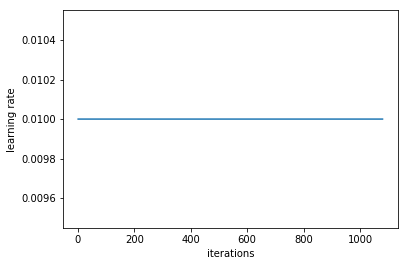

In [119]:
learn.sched.plot_lr()

### Analysing the result

In [120]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.989

### Confusion Matrix

In [121]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

[[987  13]
 [  9 991]]


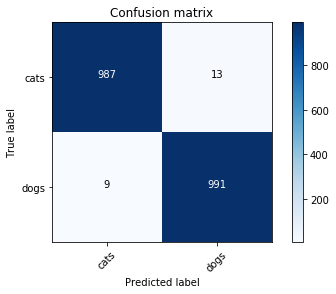

In [122]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y,preds)
plot_confusion_matrix(cm,data.classes)

# Improving the model

## Data Augmentations

In [123]:
arch=resnet34
tfms=tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-2, 3)

epoch      trn_loss   val_loss   accuracy                      
    0      0.045772   0.026805   0.9895    
    1      0.037039   0.02676    0.991                         
    2      0.031486   0.025112   0.991                         



[array([0.02511]), 0.991]

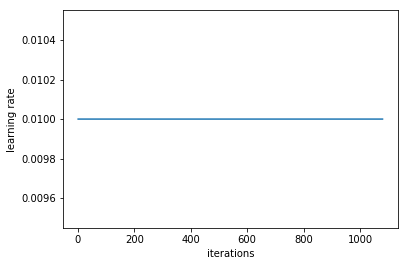

In [124]:
learn.sched.plot_lr()

### Analysing the result

In [125]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.991

### Confusion Matrix

In [126]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

[[990  10]
 [  8 992]]


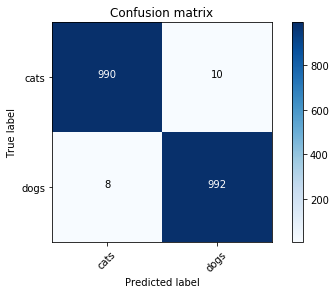

In [127]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y,preds)
plot_confusion_matrix(cm,data.classes)

### With False precompute 

In [134]:
arch=resnet34
tfms=tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.precompute = False
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.05902    0.030756   0.9905    
    1      0.05382    0.026769   0.992                        
    2      0.04138    0.024996   0.9915                       


[array([0.025]), 0.9915]

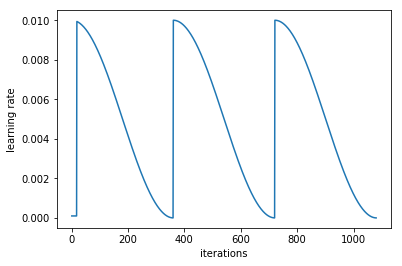

In [135]:
learn.sched.plot_lr()

### Analysing the result

In [136]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.9935

### Confusion Matrix

In [137]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

[[992   8]
 [  5 995]]


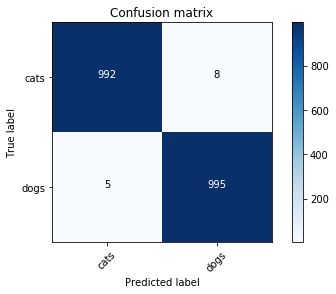

In [138]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y,preds)
plot_confusion_matrix(cm,data.classes)

## Differential Learning Rate

In [139]:
arch=resnet34
tfms=tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.unfreeze()
lr = np.array([1e-4, 1e-3, 1e-2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.049715   0.030436   0.9915    
    1      0.05402    0.029524   0.9905                       
    2      0.052151   0.029713   0.989                        
    3      0.048245   0.028842   0.9905                       
    4      0.037962   0.02785    0.99                         
    5      0.040895   0.027477   0.99                         
    6      0.040666   0.027727   0.9905                       


[array([0.02773]), 0.9905]

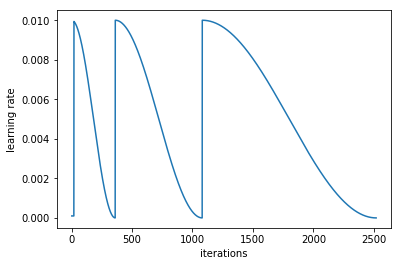

In [140]:
learn.sched.plot_lr()

### Analysing the result

In [141]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.993

### Confusion Matrix

In [142]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

[[989  11]
 [  3 997]]


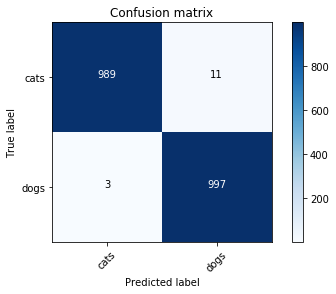

In [143]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y,preds)
plot_confusion_matrix(cm,data.classes)

## Analyzing the results: looking at pictures


As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

In [37]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [38]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [39]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [40]:
def load_img_id(ds, idx): return np.array(Image.open(PATH+ds.fnames[idx]))

In [41]:
def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


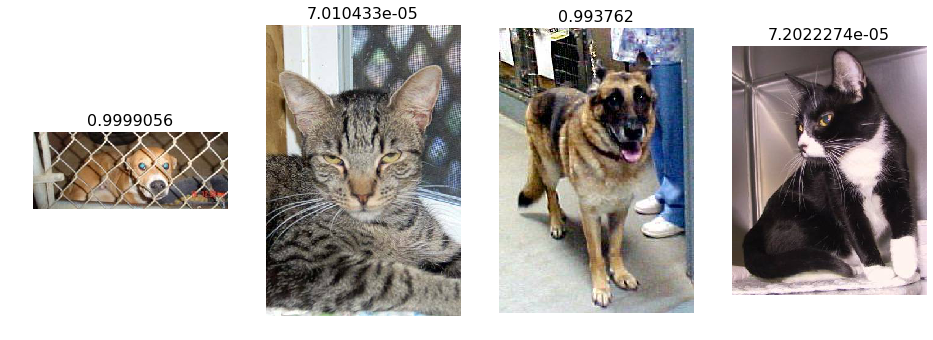

In [42]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


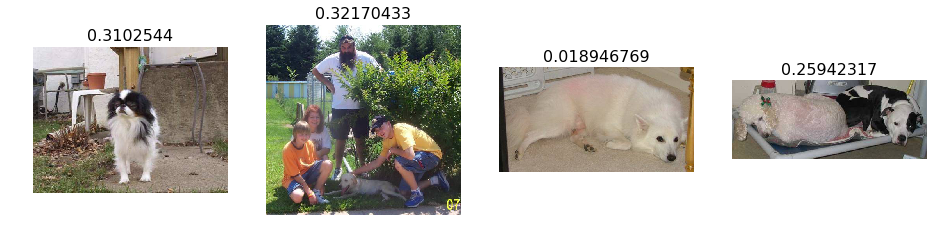

In [43]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [44]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most correct cats


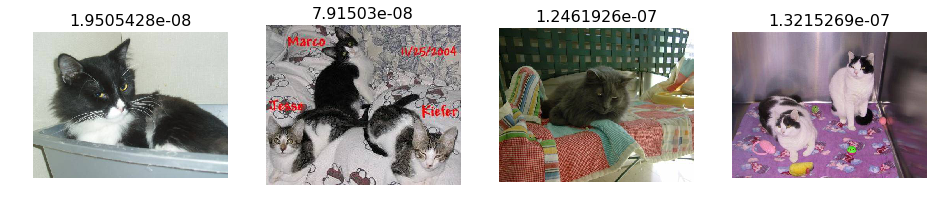

In [45]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


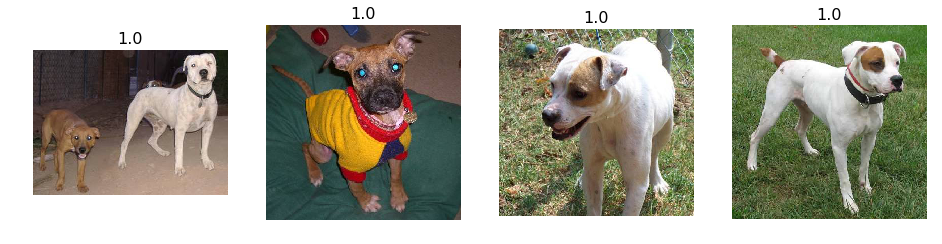

In [46]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


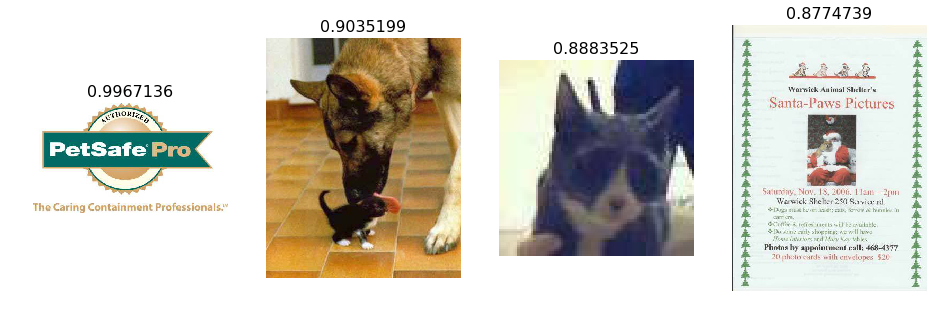

In [47]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


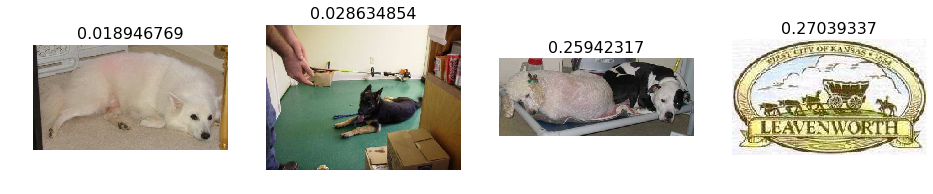

In [48]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


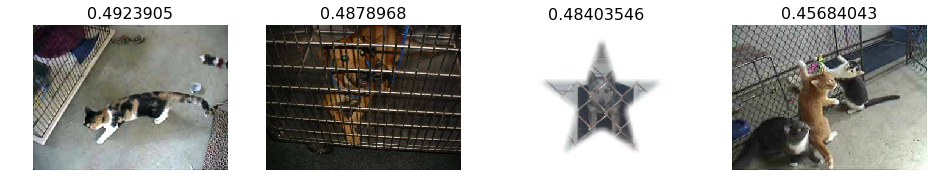

In [49]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [50]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [42]:
lrf=learn.lr_find()

 77%|███████▋  | 276/360 [00:02<00:00, 116.58it/s, loss=0.438]


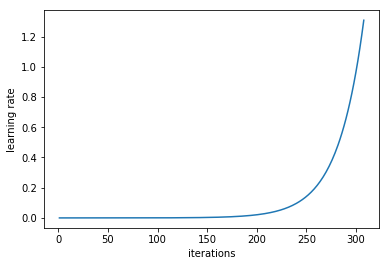

In [43]:
learn.sched.plot_lr()

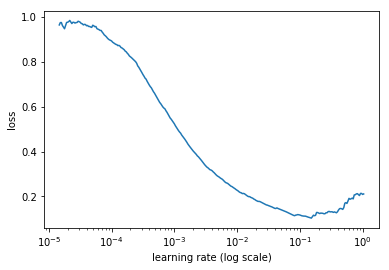

In [44]:
learn.sched.plot()

## Testing The Model

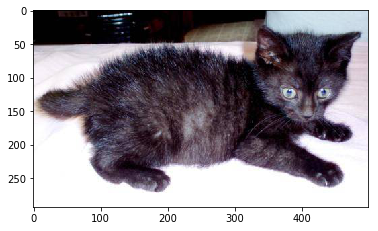

In [45]:
files = !ls {PATH}test1 | head
img = plt.imread(f'{PATH}test1/{files[1]}')
plt.imshow(img);

In [46]:
learn.predict(img)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()